In [184]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

#DP9 - Pacientes COVID-19 en UCI por grupo de edad
#DP10 - Fallecidos con COVID-19 por grupo de edad: Descripción
#DP16 - Casos por genero y grupo de edad

casos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto16/CasosGeneroEtario_T.csv')
casos = casos.drop(0).rename(columns={'Grupo de edad': 'Fecha'}).set_index('Fecha')
casos = casos.astype('int32')
casos_H = casos[casos.columns[:int(len(casos.columns)/2)]]
casos_M = casos[casos.columns[int(len(casos.columns)/2):]]
casos_M.columns= casos.columns[:int(len(casos.columns)/2)]
casos_H = casos_H.apply(pd.to_numeric)
casos_M = casos_M.apply(pd.to_numeric)
casos_m = casos_H + casos_M
casos_m.index = pd.to_datetime(casos_m.index)
# print(casos_m.index)
# hay un dia que no hubieron nuevos casos, borrando
casos_m = casos_m.drop(pd.Timestamp('2020-10-02'))
casos_m = casos_m.resample('D').interpolate('quadratic')
# casos_m = casos_m.resample('7D').sum().iloc[:-1].resample('1D').ffill().div(7).rolling(21).mean()

casos_m = casos_m.diff()
# hay un nuevo caso negativo, arreglando
casos_m.loc['2020-04-04']['00 - 04 años'] = 1
casos_m.loc['2020-04-05']['00 - 04 años'] = 0


uci = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto9/HospitalizadosUCIEtario_T.csv')
uci['Grupo de edad'] = pd.to_datetime(uci['Grupo de edad'],infer_datetime_format=True)
uci = uci.rename(columns={'Grupo de edad': 'Fecha'}).set_index('Fecha')
e0_39 = list(casos_m.columns[:8])
e40_49 = list(casos_m.columns[8:10])
e50_59 = list(casos_m.columns[10:12])
e60_69 = list(casos_m.columns[12:14])
e70_9999 = list(casos_m.columns[14:])
casos_m_edadesUCI = pd.merge(casos_m[e0_39].T.sum().rename('<=39'), casos_m[e40_49].T.sum().rename('40-49'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e50_59].T.sum().rename('50-59'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e60_69].T.sum().rename('60-69'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e70_9999].T.sum().rename('>=70'), left_index=True, right_index=True)


muertes = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto10/FallecidosEtario_T.csv')
muertes = muertes.rename(columns={'Grupo de edad': 'Fecha'}).set_index('Fecha')
muertes.index = pd.to_datetime(muertes.index)
muertes['>=70'] = muertes['70-79'] + muertes['80-89'] + muertes['>=90']
muertes = muertes.drop(columns=['70-79', '80-89', '>=90'])
muertes = muertes.drop(pd.Timestamp('2020-12-28')) # sin muertes
muertes = muertes.drop(pd.Timestamp('2021-01-04')) # sin muertes
# muertes = muertes.drop(pd.Timestamp('2020-07-17')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-18')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-19')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-20')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-21')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-22')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-23')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-24')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-25')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-26')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-27')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-28')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-29')) # raro
# muertes = muertes.drop(pd.Timestamp('2020-07-30')) # raro
# muertes = muertes.resample('D').interpolate()

muertes = muertes.diff()
muertes = muertes.drop(pd.Timestamp('2020-07-17')) # raro
muertes = muertes.resample('D').interpolate()

muertes.loc['2020-07-15':'2020-07-20']
# muertes.loc['2020-07-17':'2020-07-20'].plot()
# for d in pd.date_range('2020-07-16', '2020-07-20'):
#     print(muertes.loc[d])
#     muertes.loc[d] = round(muertes.loc[d]/2, 0)
# print(muertes.loc['2020-07-17'])
# muertes.loc['2020-07-17'] = round(muertes.loc['2020-07-17']/4, 0)
# print(muertes.loc['2020-07-17'])

,<=39,40-49,50-59,60-69,>=70
Fecha,,,,,
2020-07-15,1.0,4.0,12.0,30.0,70.0
2020-07-16,3.0,3.0,10.0,30.0,58.0
2020-07-17,2.5,4.5,11.0,26.5,56.5
2020-07-18,2.0,6.0,12.0,23.0,55.0
2020-07-19,3.0,1.0,10.0,12.0,32.0
2020-07-20,5.0,2.0,11.0,28.0,84.0


<AxesSubplot:>

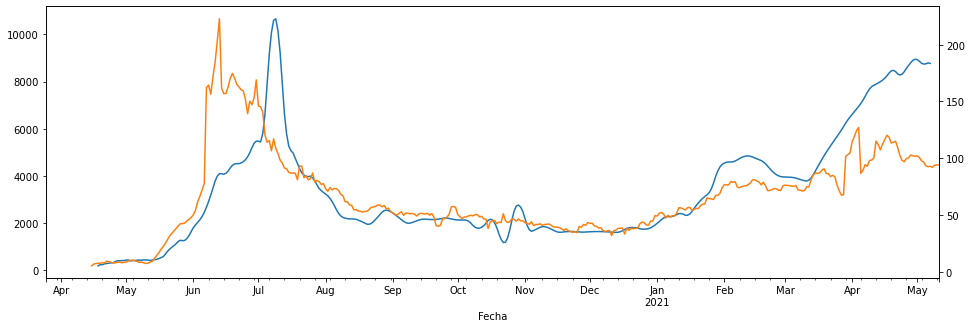

In [251]:
casos_m_edadesUCI.sum(axis=1).rolling(7).mean().shift(18).plot(figsize=(16,5))
muertes.sum(axis=1).rolling(7).mean().plot(figsize=(16,5), secondary_y=True)


In [252]:
muertes.cumsum().div(casos_m_edadesUCI.cumsum().shift(18)).dropna()

,<=39,40-49,50-59,60-69,>=70
Fecha,,,,,
2020-04-12,inf,inf,inf,inf,inf
2020-04-13,0.008772,0.020833,0.046512,0.136364,1.384615
2020-04-14,0.005102,0.011111,0.056338,0.069767,1.181818
2020-04-15,0.003012,0.007299,0.030303,0.043478,0.682927
2020-04-16,0.002463,0.005348,0.032680,0.052083,0.692308
...,...,...,...,...,...
2021-05-03,0.000874,0.004568,0.014101,0.048463,0.188534
2021-05-04,0.000871,0.004546,0.014039,0.048264,0.187869
2021-05-05,0.000867,0.004528,0.013972,0.048038,0.187146


<AxesSubplot:xlabel='Fecha'>

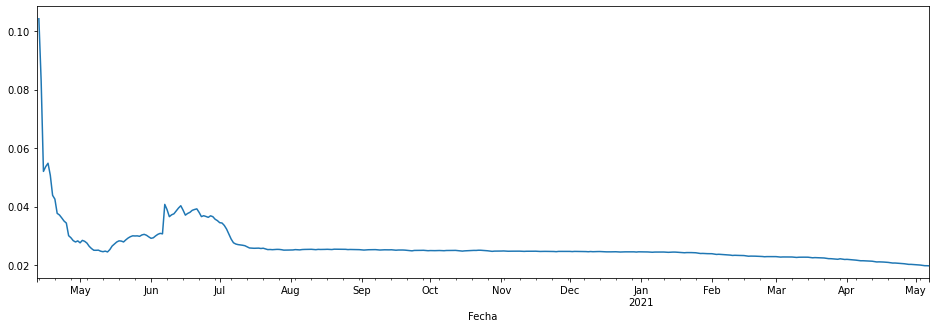

In [255]:
muertes.cumsum().sum(axis=1).div(casos_m_edadesUCI.cumsum().sum(axis=1).shift(18)).dropna().plot(figsize=(16,5))